# $\epsilon$-Distance Convergence Analysis
#### Unified Model with Multiple Strategic Agents 

#### Strategic Agent-Specific Message Weights 

James Yu, 19 December 2022

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def should_terminate(bundles, eps):
    return all([np.allclose(b[0], b[1], rtol = eps, atol = eps) for b in bundles])

def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, eps):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        historical_K.insert(0, K_new)
        historical_k.insert(0, k_new)
        historical_kappa.insert(0, kappa_new)
        if should_terminate([(K_t, K_new), (k_t, k_new), (kappa_t, kappa_new)], eps):
            return historical_K[0], historical_k[0], historical_kappa[0]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new

In [5]:
def optimal(X_init, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, eps):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(int)
    
    M_ = M(K_ss, B, R, L, delta)
    H_ = H(B, K_ss, A, L)
    E_ = E(M_, H_)
    G_ = G(A, B, E_, L, n)
    F_ = [F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n) for l in range(L)]
    g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
    
    i = 0
    while True:
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if l == L - 1 and np.allclose(X_t[l], X_new, rtol = eps, atol = eps):
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(b1, b2, a1, a2, delta = 0.9, c = 200, X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T, A = np.array([ # asymmetric
                            [0.6, 0.3, 0.1],
                            [0.4, 0.1, 0.5],
                            [0.5, 0.2, 0.3]
                    ]), 
                   tol = np.finfo(np.float64).eps, print_ = True):
    X_0 = [X_0_1 - b1, X_0_1 - b2]
    n = 3 # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c * np.identity(n), c * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [a1 * np.identity(n), a2 * np.identity(n)] # B^l = a_l I_n
    x = [b1, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    
    K_ss, k_ss, kappa_ss = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol)
    xs, rs, payoffs = optimal(X_0, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, tol)
    
    if print_:
        print("Steady-State Opinions:")
        print(xs[0][-1] + b1)
        print("Average of agendas:")
        print((b1+b2)/2)
        print()
        print("K^* (1, 2):")
        print(K_ss[0])
        print(K_ss[1])
        print()
        print("k^* (1, 2):")
        print(k_ss[0])
        print(k_ss[1])
        print()
        print("kappa^* (1, 2):")
        print(kappa_ss[0])
        print(kappa_ss[1])
    else:
        return xs[0][-1] + b1

The original example was:

In [7]:
run_simulation(0, 5, 0.5, 0.6)

Steady-State Opinions:
[[2.99613579]
 [2.99601388]
 [2.99600195]]
Average of agendas:
2.5

K^* (1, 2):
[[6.43059654 2.3439935  2.51408674]
 [2.3439935  2.01821916 1.05703513]
 [2.51408674 1.05703513 2.28571685]]
[[6.62457434 2.42816628 2.60195291]
 [2.42816628 2.05474748 1.09514893]
 [2.60195291 1.09514893 2.32557812]]

k^* (1, 2):
[[13.04617086  5.66080632  5.91090462]]
[[-9.38608793 -4.07269416 -4.25253049]]

kappa^* (1, 2):
[[-17.39881349]]
[[-8.54876211]]


and the question is whether these are the same limit opinions or different limit opinions after accounting for rounding errors.

In [8]:
run_simulation(0, 5, 0.5, 60000)

Steady-State Opinions:
[[5.]
 [5.]
 [5.]]
Average of agendas:
2.5

K^* (1, 2):
[[1.00000000e+00 1.09862798e-15 1.40761714e-15]
 [1.09862798e-15 1.00000000e+00 4.80649741e-16]
 [1.40761714e-15 4.80649741e-16 1.00000000e+00]]
[[1.00000004e+00 1.77777767e-08 2.27777764e-08]
 [1.77777767e-08 1.00000001e+00 7.77777730e-09]
 [2.27777764e-08 7.77777730e-09 1.00000002e+00]]

k^* (1, 2):
[[8.34270731e-07 3.33708293e-07 5.00562438e-07]]
[[-9.37500053e-10 -3.75000025e-10 -5.62500015e-10]]

kappa^* (1, 2):
[[-675.75936673]]
[[-5.27343805e-11]]


In the limit as the second weight goes to infinity, there is apparent consensus at the opinion of the second agenda. But this is a limiting case.

In [22]:
run_simulation(0, 5, 0.5, 0.6, c = 20000)

Steady-State Opinions:
[[2.95143991]
 [2.95143989]
 [2.95143989]]
Average of agendas:
2.5

K^* (1, 2):
[[8.48156654 3.23398226 3.44306546]
 [3.23398226 2.40444509 1.4600299 ]
 [3.44306546 1.4600299  2.70702319]]
[[8.48578458 3.23581267 3.44497579]
 [3.23581267 2.40523942 1.46085874]
 [3.44497579 1.46085874 2.70788897]]

k^* (1, 2):
[[0.26080478 0.11317201 0.11813246]]
[[-0.18121719 -0.07863627 -0.08208297]]

kappa^* (1, 2):
[[-0.00435574]]
[[-0.00210125]]


In [9]:
run_simulation(0, 5, 0.5, 0.6, c = 0.001)

Steady-State Opinions:
[[3.4859028 ]
 [3.17343934]
 [3.23660598]]
Average of agendas:
2.5

K^* (1, 2):
[[1.00051755e+00 2.15081435e-04 2.75593419e-04]
 [2.15081435e-04 1.00009410e+00 9.40968168e-05]
 [2.75593419e-04 9.40968168e-05 1.00023530e+00]]
[[1.00074474e+00 3.09506955e-04 3.96535464e-04]
 [3.09506955e-04 1.00013541e+00 1.35410603e-04]
 [3.96535464e-04 1.35410603e-04 1.00033847e+00]]

k^* (1, 2):
[[5.95076759 2.47142506 3.17561577]]
[[-5.94645549 -2.46970382 -3.1730129 ]]

kappa^* (1, 2):
[[-171446.70943223]]
[[-118936.58721259]]


The lower the message cost is, the greater the disparity between the steady-state opinions.

In [60]:
run_simulation(-2000000, 500000, 0.5, 0.6, c = 0.001)

Steady-State Opinions:
[[-257048.5977707 ]
 [-413280.33096974]
 [-381697.01236092]]
Average of agendas:
-750000.0

K^* (1, 2):
[[1.00051755e+00 2.15081435e-04 2.75593419e-04]
 [2.15081435e-04 1.00009410e+00 9.40968168e-05]
 [2.75593419e-04 9.40968168e-05 1.00023530e+00]]
[[1.00074474e+00 3.09506955e-04 3.96535464e-04]
 [3.09506955e-04 1.00013541e+00 1.35410603e-04]
 [3.96535464e-04 1.35410603e-04 1.00033847e+00]]

k^* (1, 2):
[[2975383.79362803 1235712.53043289 1587807.88658898]]
[[-2973227.74481416 -1234851.91233711 -1586506.45110562]]

kappa^* (1, 2):
[[-4.28616774e+16]]
[[-2.97341468e+16]]


In [61]:
run_simulation(-2000000, 500000, 0.5, 0.6, delta = 0.5, c = 0.001)

Steady-State Opinions:
[[-415379.58458623]
 [-479815.73402876]
 [-463051.20819921]]
Average of agendas:
-750000.0

K^* (1, 2):
[[1.00051787e+00 2.15216516e-04 2.75766441e-04]
 [2.15216516e-04 1.00009416e+00 9.41559183e-05]
 [2.75766441e-04 9.41559183e-05 1.00023545e+00]]
[[1.00074441e+00 3.09367967e-04 3.96357447e-04]
 [3.09367967e-04 1.00013535e+00 1.35349792e-04]
 [3.96357447e-04 1.35349792e-04 1.00033832e+00]]

k^* (1, 2):
[[1217500.82402722  497501.33690076  684996.12949357]]
[[-1215307.28789544  -496624.23294212  -683678.6623402 ]]

kappa^* (1, 2):
[[-1.43906477e+15]]
[[-9.97362401e+14]]


In [10]:
run_simulation(0, 50000000, 0.5, 0.6)

Steady-State Opinions:
[[29961357.93166986]
 [29960138.75482544]
 [29960019.46809755]]
Average of agendas:
25000000.0

K^* (1, 2):
[[6.43059654 2.3439935  2.51408674]
 [2.3439935  2.01821916 1.05703513]
 [2.51408674 1.05703513 2.28571685]]
[[6.62457434 2.42816628 2.60195291]
 [2.42816628 2.05474748 1.09514893]
 [2.60195291 1.09514893 2.32557812]]

k^* (1, 2):
[[1.30461709e+08 5.66080632e+07 5.91090462e+07]]
[[-93860879.28679268 -40726941.5626741  -42525304.89759514]]

kappa^* (1, 2):
[[-1.73988135e+15]]
[[-8.54876211e+14]]


These limit opinions do appear different, but note the very large $\kappa^*$ term which when multiplied by an error can cause errors to explode.

In [40]:
run_simulation(0, 50000000, 0.5, 0.6, delta = 0.5936)

Steady-State Opinions:
[[29523969.1876968 ]
 [29523942.21798625]
 [29523942.22018254]]
Average of agendas:
25000000.0

K^* (1, 2):
[[2.16582387 0.49754769 0.56421571]
 [0.49754769 1.21658699 0.22240098]
 [0.56421571 0.22240098 1.35276575]]
[[2.16828273 0.49861201 0.56534099]
 [0.49861201 1.21704908 0.22288199]
 [0.56534099 0.22288199 1.35330705]]

k^* (1, 2):
[[1528676.41911293  660166.07559384  706191.9836902 ]]
[[-1063830.28221317  -459424.10386284  -491432.87509177]]

kappa^* (1, 2):
[[-8.06566539e+11]]
[[-3.89605145e+11]]


In [11]:
run_simulation(0, 50000000, 0.5, 0.6, delta = 0.5)

Steady-State Opinions:
[[29515625.52159192]
 [29515614.97813952]
 [29515615.39493213]]
Average of agendas:
25000000.0

K^* (1, 2):
[[1.7980716  0.33927461 0.39197709]
 [0.33927461 1.14779705 0.15118689]
 [0.39197709 0.15118689 1.25947003]]
[[1.79900555 0.33967797 0.39240842]
 [0.33967797 1.14797224 0.15136887]
 [0.39240842 0.15136887 1.25968787]]

k^* (1, 2):
[[580367.98586168 249570.8999515  272718.06722077]]
[[-403505.30112752 -173517.50897707 -189603.16373026]]

kappa^* (1, 2):
[[-1.58864718e+11]]
[[-7.66870047e+10]]


If we decrease $\delta$, note now that the opinions are no longer monotonically sorted the way they were in the previous case. We can try to do a plot:

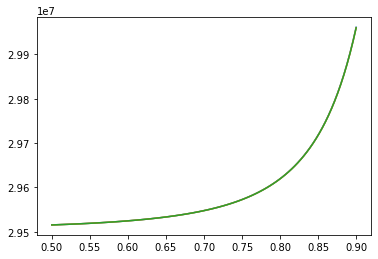

In [12]:
delta_grid = np.linspace(0.5, 0.9, 100)
generated_data = [run_simulation(0, 50000000, 0.5, 0.6, delta = d, print_ = False) for d in delta_grid]
plt.plot(delta_grid, [g[0] for g in generated_data])
plt.plot(delta_grid, [g[1] for g in generated_data])
plt.plot(delta_grid, [g[2] for g in generated_data])

but this plot is not very useful since from the perspective of the given scale (1e7 = 1 * 10^7 = 10 million, so the y-axis is in 10s of millions), all the opinions align.

Here is an example to show the difficulties with numerical error. Suppose we have some number:

In [13]:
2.0

2.0

But after rounding error, we actually get this number in the computer:

In [14]:
2.00000001

2.00000001

Suppose we want to do an operation like $a\cdot x$ for some constant $a$. If $a$ is very small, e.g. $a = 5$, then the true result of $ax$ is $ax = 2*5= 10$. But with the error:

In [15]:
2.00000001 * 5

10.00000005

The error is also multiplied by $5$, but it is still quite small. Now suppose $a = 10^{11}$:

In [16]:
2.0 * 10**11

200000000000.0

In [17]:
2.00000001 * 10**11

200000001000.0

Now our result is off by 1000, which is non-negligible.

In [20]:
run_simulation(0, 5, 0, 0.5)

Steady-State Opinions:
[[5.]
 [5.]
 [5.]]
Average of agendas:
2.5

K^* (1, 2):
[[7.08984934 2.63005757 2.81273234]
 [2.63005757 2.14236232 1.18656429]
 [2.81273234 1.18656429 2.42126355]]
[[7.73293909 2.90911995 3.10400474]
 [2.90911995 2.26346601 1.3129272 ]
 [3.10400474 1.3129272  2.55332651]]

k^* (1, 2):
[[12.13424534  5.26528994  5.49698273]]
[[1.32084974e-14 5.72521004e-15 6.01058375e-15]]

kappa^* (1, 2):
[[-12.71282003]]
[[-1.23849394e-29]]


In [84]:
run_simulation(-20, 5, 0.5, 0.6, c = 0.001, delta = 0.9)

Steady-State Opinions:
[[-2.57048598]
 [-4.13280331]
 [-3.81697012]]
Average of agendas:
-7.5

K^* (1, 2):
[[1.00051755e+00 2.15081435e-04 2.75593419e-04]
 [2.15081435e-04 1.00009410e+00 9.40968168e-05]
 [2.75593419e-04 9.40968168e-05 1.00023530e+00]]
[[1.00074474e+00 3.09506955e-04 3.96535464e-04]
 [3.09506955e-04 1.00013541e+00 1.35410603e-04]
 [3.96535464e-04 1.35410603e-04 1.00033847e+00]]

k^* (1, 2):
[[29.75383794 12.3571253  15.87807887]]
[[-29.73227745 -12.34851912 -15.86506451]]

kappa^* (1, 2):
[[-4286167.73580572]]
[[-2973414.68031478]]


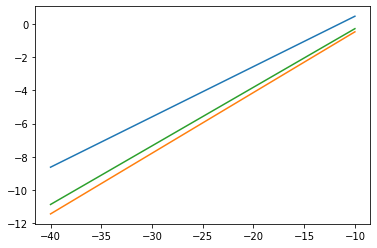

In [83]:
delta_grid = np.linspace(-10, -40, 100)
generated_data = [run_simulation(d, 5, 0.5, 0.6, c = 0.001, print_ = False, delta = 0.9, tol = 10**-8) for d in delta_grid]
plt.plot(delta_grid, [g[0] for g in generated_data])
plt.plot(delta_grid, [g[1] for g in generated_data])
plt.plot(delta_grid, [g[2] for g in generated_data])

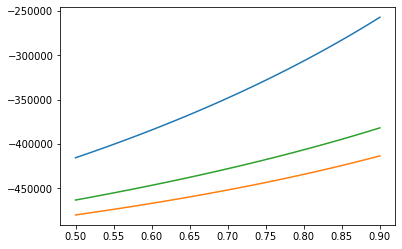

In [74]:
delta_grid = np.linspace(0.5, 0.9, 100)
generated_data = [run_simulation(-2000000, 500000, 0.5, 0.6, c = 0.001, delta = d, print_ = False, tol = 10**-8) for d in delta_grid]
plt.plot(delta_grid, [g[0] for g in generated_data])
plt.plot(delta_grid, [g[1] for g in generated_data])
plt.plot(delta_grid, [g[2] for g in generated_data])